# Discrete A2C to CartPole-v0
- 발표자 : 최찬혁

이 코드는 CartPole-v0 환경에 PyTorch를 이용하여 A2C 알고리즘을 적용한 코드입니다.

## import module

In [1]:
import random
from typing import List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

## Set random seed
재현성을 위해 seed를 설정한다.

In [2]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 915
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Network
2가지의 기본 신경망을 구성합니다.

Actor 신경망은 $\pi\left( a | s \right)$을 예측합니다. action space가 discrete이므로 확률값으로 예측해야 됩니다.

Critic 신경망은 $V \left( s \right)$를 예측합니다.

이외 initialize_uniformly라는 함수는 각각의 layer 안에 있는 weight를 지정된 범위에서 균등분포로 초기화하는 역할을 합니다.

In [3]:
def initialize_uniformly(layer: nn.Linear, init_w: float = 0.5):
    """Initialize the weights and bias in [-init_w, init_w]."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)


class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """초기화"""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 24)
        self.out_layer = nn.Linear(24, out_dim)     
        initialize_uniformly(self.hidden1)
        initialize_uniformly(self.out_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        
        output = F.softmax(self.out_layer(x))

        
        return output
    
class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 24)
        self.out = nn.Linear(24, 1)
        
        initialize_uniformly(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        value = self.out(x)
        
        return value

## A2C Agent
A2CAgent라는 클래스를 정의합니다.

select_action : 주어진 state에 대해 action을 선택합니다. train/test 경우에 따라 다른 action을 사용하게 되는데 train의 경우 정규분포에서 추출하게 되고 test의 경우 최빈값인 평균을 추출합니다. 또한 train의 경우 state, log-probability로 리스트에 저장합니다.

step : 현재 환경에서 주어진 action을 시행하고 난 후 state, reward, done을 추출합니다. 또한 train의 경우, 이 trajectory를 리스트에 저장합니다.

update_model : 다음 식을 이용하여 networks를 업데이트합니다.

train : 실제로 환경을 돌리면서 학습을 진행합니다.

test : 환경을 리셋한 후 평가합니다.

_plot : episode에서 얻은 score 및 critic loss, actor loss를 plot합니다. 이는 train 중 일정 주기마다 작동됩니다.

In [4]:
class A2CAgent:
    """A2CAgent interacting with environment.
        
    Atribute:
        env (gym.Env): openAI Gym environment
        gamma (float): discount factor
        entropy_weight (float): rate of weighting entropy into the loss function
        device (torch.device): cpu / gpu
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        actor_optimizer (optim.Optimizer) : optimizer of actor
        critic_optimizer (optim.Optimizer) : optimizer of critic
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(self, env: gym.Env, gamma: float, entropy_weight: float):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = 2
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)
        
        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=5e-3)
        
        # transition (state, log_prob, next_state, reward, done)
        self.transition: list = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
        
    def select_action(self, state: np.ndarray):
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        output = self.actor(state)
        selected_action = torch.argmax(output)
        action = selected_action.cpu().detach().numpy()
        action = int(action)
        if not self.is_test:
            log_prob = torch.log(output[action])
            self.transition = [state, log_prob]
        
        return action
    
    def step(self, action) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)
        if not self.is_test:
            self.transition.extend([next_state, reward, done])           
    
        return next_state, reward, done
    
    def update_model(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""  
        state, log_prob, next_state, reward, done = self.transition

        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done
        next_state = torch.FloatTensor(next_state).to(self.device)
        pred_value = self.critic(state)
        targ_value = reward + self.gamma * self.critic(next_state) * mask
        value_loss = F.smooth_l1_loss(pred_value, targ_value.detach())
        
        # update value
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # advantage = Q_t - V(s_t)
        advantage = (targ_value - pred_value).detach()  # not backpropagated
        policy_loss = -advantage * log_prob
        policy_loss += self.entropy_weight * -log_prob  # entropy maximization

        # update policy
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        return policy_loss.item(), value_loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        actor_losses, critic_losses, scores = [], [], []
        state = self.env.reset()
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            
            actor_loss, critic_loss = self.update_model()
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            
            state = next_state
            score += reward
            
            # if episode ends
            if done:         
                state = env.reset()
                scores.append(score)
                score = 0                
            
            # plot
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        self.env.close()
    
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment

In [5]:
env_id = "CartPole-v0"
env = gym.make(env_id)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Initialize

In [6]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2

agent = A2CAgent(env, gamma, entropy_weight)

cuda


## Train

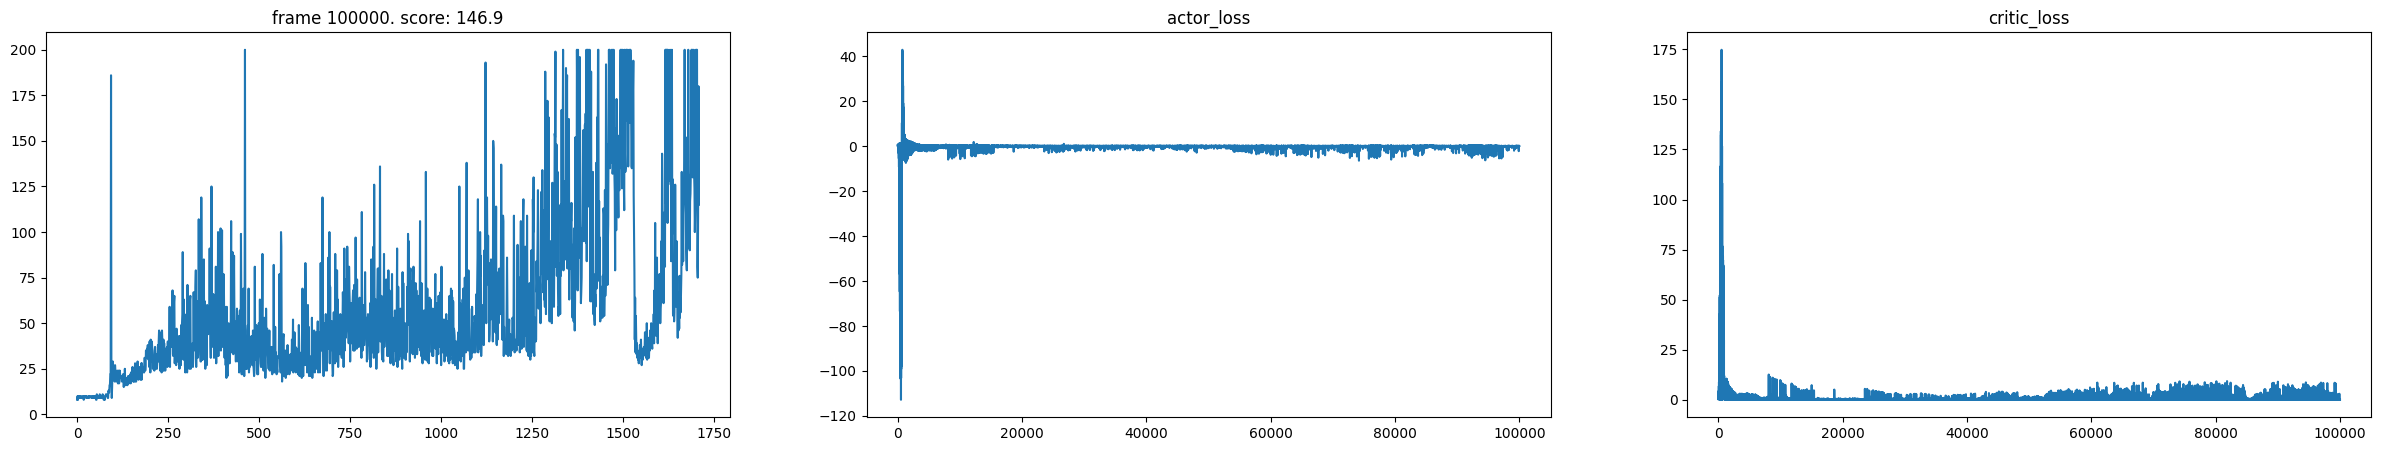

In [7]:
agent.train(num_frames)

## Test

In [8]:
# test
frames = agent.test()

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
<ipython-input-3-7bad08947653>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.out_layer(x))


score:  149.0
